In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import src.utils as utils
import src.dataset as dataset
import src.trainer as trainer
import src.metrics as metrics
import cv2 as cv
from sklearn.metrics import classification_report

!pip install torchmetrics

# Modelo Final

A partir del modelo baseline y junto a los análisis posteriores de desbalanceo de clases y similitud de clases haremos uso de diversas técnicas para intentar mejorar los resultados obtenidos previamente

## Dataset

In [ ]:
utils.download_plantvillage_dataset_in_collab()

In [6]:
dataset_path = "/kaggle/input/plantvillage-dataset/plantvillage dataset/color/"
df = utils.build_color_spa_dataset(dataset_path)
df

,Format,Species,Healthy,Disease,FileName
0,color,Tomato,False,Late_blight,781e93a9-2059-42de-8075-658033a6abf7___RS_Late...
1,color,Tomato,False,Late_blight,283ff0be-6e5e-4b4e-bf21-639780b77ffc___GHLB2 L...
2,color,Tomato,False,Late_blight,0db85707-41f9-42df-ba3b-842d14f00a68___GHLB2 L...
3,color,Tomato,False,Late_blight,078a999d-6e6f-427e-a1e6-80b4d2df2bae___GHLB2 L...
4,color,Tomato,False,Late_blight,3dcee9ed-43bb-45a9-8cff-641b3dd62179___RS_Late...
...,...,...,...,...,...
54300,color,Corn_(maize),True,None,8cdec02e-6273-452f-8681-1319a74d3698___R.S_HL ...
54301,color,Corn_(maize),True,None,c9c333a8-30ed-4163-adf1-c65379dac7ac___R.S_HL ...
54302,color,Corn_(maize),True,None,85581bfb-0508-4cea-a76c-b929fea867a1___R.S_HL ...
54303,color,Corn_(maize),True,None,0b703646-9307-401b-bd31-ace32353d467___R.S_HL ...


In [8]:
# Duplicar columna "Enfermedad" como "Label", por cuestiones prácticas
df["Label"] = df["Enfermedad"]

# Codificar las etiquetas compuestas como números
df["Label_id"] = df["Label"].astype("category").cat.codes

# Crear el diccionario de mapeo id → etiqueta compuesta
label_map = dict(enumerate(df["Label"].astype("category").cat.categories))

# Número de clases únicas
NUM_CLASSES = len(label_map)

print(f"Número de clases: {NUM_CLASSES}")

Número de clases: 21


In [10]:
SEED = 42

# Split 85% train, 15% valid
train_df, valid_df = train_test_split(df, test_size=0.15, stratify=df["Label_id"], random_state=SEED)
len(valid_df)

8146

### Reducción del dataset para agilizar el desarrollo

Utilizamos una fracción del dataset para poder iterar las modificaciones del modelo ágilmente. Aunque último modelo se corrió con todo el dataset dejamos el siguiente código como evidencia de estas iteraciones

In [ ]:
USE_SMALL_TRAIN = False 
TRAIN_FRAC = 0.2


def stratified_fraction_indices(y, frac=0.2, seed=1337):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=seed)
    ((idx_small, _),) = sss.split(np.zeros_like(y), y)  # ahora train_size=frac
    return idx_small


base_train_df = train_df
if USE_SMALL_TRAIN:
    idx = stratified_fraction_indices(train_df["Label_id"].values, frac=TRAIN_FRAC, seed=1337)
    base_train_df = train_df.iloc[idx].reset_index(drop=True)

total_train = len(train_df)
subset_train = len(base_train_df)

print(f"Total imágenes en train: {total_train}")
print(f"Usando en subset: {subset_train} ({subset_train/total_train:.1%} del train)")

Total imágenes en train: 46159
Usando en subset: 46159 (100.0% del train)


### **Preprocesamiento y Data Augmentation**

Mantendremos las mismas transformaciones que se vieron en el modelo baseline. Haremos:


* **Redimensionamiento:** Ajustaremos las imágenes de 256×256 a 224×224 píxeles para adaptarlas a la entrada de **ResNet18**.


* **Normalización:** Aplicaremos normalización utilizando los valores de *mean* y *std* por canal RGB empleados en ImageNet.


* **Data Augmentation (estrategia conservadora):**
  Con el objetivo de incrementar la variabilidad artificial de los datos y mejorar la capacidad de generalización del modelo, se aplicarán las siguientes transformaciones:

  * **RandomResizedCrop:** Recorta y escala aleatoriamente regiones de la imagen.
  * **RandomHorizontalFlip:** Invierte horizontalmente la imagen con una probabilidad del 50%.
  * **RandomRotation(20):** Rota aleatoriamente hasta ±20°.
  * **ColorJitter:** Ajusta brillo, contraste, saturación y tono de forma aleatoria.
  * **RandomErasing:** Elimina un área aleatoria de la imagen para simular oclusiones.

In [ ]:
# Normalización estándar ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

BATCH_SIZE = 128

train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomResizedCrop((224, 224), scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.03),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3)),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

In [ ]:
train_dataset = dataset.PlantVillageDataset(base_train_df, dataset_path, transform=train_transform)
valid_dataset = dataset.PlantVillageDataset(valid_df, dataset_path, transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

data_dict = {
    "train": train_loader,
    "valid": valid_loader,
    "image_width": 224,
    "image_height": 224,
}


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## Desbalance de clases y función de pérdida

Se obtiene la cantidad de imágenes por clase, luego se calcula el peso inverso de cada clase para dar más importancia a las clases menos representadas y por último los normalizamos para que la suma sea igual al número de clases.

In [ ]:
counts = (base_train_df["Label_id"].value_counts().sort_index().to_numpy(dtype=np.float32))

class_weights = torch.tensor(1.0 / (counts + 1e-6), dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(counts)
class_weights = class_weights.to(device)

FocalLoss es una modificación de CrossEntropyLoss que reduce el impacto de las muestras que el modelo predice correctamente y aumenta el enfoque en las que todavía le cuesta. 

Se controla mediante el parámetro gamma, si este es igual a cero su funcionamiento es equivalente a CrossEntropy. A mayor gamma mayor será el peso sobre las clases difíciles de predecir correctamente. 

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean", label_smoothing=0.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # tensor de pesos por clase, como en CrossEntropyLoss
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Calcular cross entropy con label smoothing
        ce_loss = F.cross_entropy(
            inputs,
            targets,
            weight=self.alpha,
            reduction="none",
            label_smoothing=self.label_smoothing,
        )

        # Calcular probabilidades
        pt = torch.exp(-ce_loss)

        # Aplicar focal weight: (1-pt)^gamma
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
criterion_focal = FocalLoss(alpha=class_weights, gamma=1.5, label_smoothing=0.05)

## Model

Debido a los buenos resultados que obtuvimos con el modelo baseline decidimos continuar con ResNet18. Podemos recordar las razones de esta elección (también descriptas en el notebook baseline)

* modelo preentrenado con ImageNet, por lo que ya ha aprendido características generales como bordes, texturas y formas.
* menor costo computacional que otras redes de la familia, lo que nos permite tener un primer resultado rápido y pudiendo incluso entrenar por varias épocas.
* su (relativamente reducida) complejidad la hace menos propensa al overfitting, problema que se intenta evitar en un baseline.
* uso de conexiones residuales, que mejoran flujo de gradiente en redes profundas y evita el problema de "vanish gradient".
* suele establecer una línea base razonable de accuracy y F1-score

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [ ]:
cv.setNumThreads(0)

In [ ]:
# Info de loaders e imagen
data_dict = {
    "train": train_loader,
    "valid": valid_loader,
    "image_width": 224,
    "image_height": 224,
}

# TensorBoard
writer = {
    "train": SummaryWriter(log_dir="runs/plant_train"),
    "valid": SummaryWriter(log_dir="runs/plant_valid"),
}

## Entrenamiento

Utilizamos entrenamiento progresivo en múltiples fases. Lo hicimos para evitar sobreajustar y aprovechar mejor las características ya aprendidas, el entrenamiento se realizó en tres fases:

### Fase 1 - Linear Probe

Únicamente entrenamos la capa final (fully connected) dado que las primeras ya contienen información general de imágenes (bordes y texturas). El entrenar solo la cabeza le permitirá al modelo mapear esa información a las clases especificas de nuestro dominio. 

In [ ]:
early_stop_metric = "valid_f1_macro"

In [ ]:
# Congelar backbone para linear probe
for p in model.parameters():
    p.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

# 2) Optimizer (solo la cabeza)
optimizer = AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",  # 'max' porque queremos maximizar F1
    factor=0.5,  # reducir LR a la mitad
    patience=3,  # esperar 3 epochs sin mejora
    verbose=True,
)

# 3) Métrica (macro)
metric = MulticlassAccuracy(num_classes=NUM_CLASSES, average="macro").to(device)

history_s1 = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion_focal,
    data=data_dict,
    epochs=10,
    scheduler=scheduler,
    tb_writer=writer,
    early_stop_metric=early_stop_metric,
    best_ckpt_path="best_s1.pth",
)

Epoch 1/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 1 | LR: 1.00e-03
  Train - Loss: 0.3682, Acc: 0.6712, F1: 0.5475
  Valid - Loss: 0.1865, Acc: 0.8283, F1: 0.7185
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.7185)


Epoch 2/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 2 | LR: 1.00e-03
  Train - Loss: 0.2024, Acc: 0.8116, F1: 0.6870
  Valid - Loss: 0.1584, Acc: 0.8602, F1: 0.7608
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.7608)


Epoch 3/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 3 | LR: 1.00e-03
  Train - Loss: 0.1800, Acc: 0.8319, F1: 0.7113
  Valid - Loss: 0.1377, Acc: 0.8905, F1: 0.7976
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.7976)


Epoch 4/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 4 | LR: 1.00e-03
  Train - Loss: 0.1728, Acc: 0.8377, F1: 0.7199
  Valid - Loss: 0.1432, Acc: 0.8862, F1: 0.8060
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.8060)


Epoch 5/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 5 | LR: 1.00e-03
  Train - Loss: 0.1642, Acc: 0.8490, F1: 0.7311
  Valid - Loss: 0.1408, Acc: 0.8807, F1: 0.7901


Epoch 6/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 6 | LR: 1.00e-03
  Train - Loss: 0.1614, Acc: 0.8526, F1: 0.7357
  Valid - Loss: 0.1376, Acc: 0.8813, F1: 0.7697


Epoch 7/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 7 | LR: 1.00e-03
  Train - Loss: 0.1586, Acc: 0.8543, F1: 0.7380
  Valid - Loss: 0.1367, Acc: 0.8924, F1: 0.8140
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.8140)


Epoch 8/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 8 | LR: 1.00e-03
  Train - Loss: 0.1524, Acc: 0.8642, F1: 0.7470
  Valid - Loss: 0.1315, Acc: 0.8989, F1: 0.8182
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.8182)


Epoch 9/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 9 | LR: 1.00e-03
  Train - Loss: 0.1567, Acc: 0.8572, F1: 0.7419
  Valid - Loss: 0.1334, Acc: 0.8869, F1: 0.7831


Epoch 10/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 10 | LR: 1.00e-03
  Train - Loss: 0.1533, Acc: 0.8627, F1: 0.7459
  Valid - Loss: 0.1362, Acc: 0.8800, F1: 0.7754


### Fase 2 - Fine-tuning parcial

Además de la capa final también desbloquearemos para entrenar la layer4 (convolucional). En ella se encuentran características más específicas del dominio de ImageNet que buscaremos adaptar a las texturas y patrones de las hojas de las plantas.

In [ ]:
model.load_state_dict(torch.load("/content/best_s1.pth", map_location=device))

<All keys matched successfully>

In [ ]:
# PASO 2
for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.requires_grad = True
for m in model.layer4.modules():  # BN de layer4 en train
    if isinstance(m, nn.BatchNorm2d):
        m.train()
        m.requires_grad_(True)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)

history_s2 = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion_focal,
    data=data_dict,
    epochs=10,
    scheduler=scheduler,
    tb_writer=writer,
    early_stop_metric=early_stop_metric,
    best_ckpt_path="best_s2.pth",
)

Epoch 1/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 1 | LR: 3.00e-04
  Train - Loss: 0.1214, Acc: 0.9057, F1: 0.8147
  Valid - Loss: 0.0859, Acc: 0.9519, F1: 0.9083
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9083)


Epoch 2/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 2 | LR: 3.00e-04
  Train - Loss: 0.0756, Acc: 0.9565, F1: 0.9043
  Valid - Loss: 0.0665, Acc: 0.9710, F1: 0.9627
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9627)


Epoch 3/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 3 | LR: 3.00e-04
  Train - Loss: 0.0648, Acc: 0.9677, F1: 0.9300
  Valid - Loss: 0.0635, Acc: 0.9733, F1: 0.9536


Epoch 4/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 4 | LR: 3.00e-04
  Train - Loss: 0.0608, Acc: 0.9710, F1: 0.9377
  Valid - Loss: 0.0541, Acc: 0.9811, F1: 0.9651
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9651)


Epoch 5/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 5 | LR: 3.00e-04
  Train - Loss: 0.0555, Acc: 0.9769, F1: 0.9506
  Valid - Loss: 0.0523, Acc: 0.9790, F1: 0.9633


Epoch 6/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 6 | LR: 3.00e-04
  Train - Loss: 0.0547, Acc: 0.9766, F1: 0.9469
  Valid - Loss: 0.0505, Acc: 0.9827, F1: 0.9725
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9725)


Epoch 7/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 7 | LR: 3.00e-04
  Train - Loss: 0.0505, Acc: 0.9817, F1: 0.9634
  Valid - Loss: 0.0487, Acc: 0.9855, F1: 0.9774
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9774)


Epoch 8/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 8 | LR: 3.00e-04
  Train - Loss: 0.0483, Acc: 0.9835, F1: 0.9660
  Valid - Loss: 0.0501, Acc: 0.9840, F1: 0.9696


Epoch 9/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 9 | LR: 3.00e-04
  Train - Loss: 0.0483, Acc: 0.9841, F1: 0.9682
  Valid - Loss: 0.0479, Acc: 0.9857, F1: 0.9759


Epoch 10/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 10 | LR: 3.00e-04
  Train - Loss: 0.0481, Acc: 0.9832, F1: 0.9650
  Valid - Loss: 0.0472, Acc: 0.9852, F1: 0.9693


### Fase 3 – Fine-tuning completo

Entrenaremos todas las capas del modelo para ajustar completamente las representaciones y maximizar el rendimiento en el dominio específico.

In [ ]:
model.load_state_dict(torch.load("best_s2.pth", map_location=device))

for p in model.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
history_s3 = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion_focal,
    data=data_dict,
    epochs=12,
    scheduler=scheduler,
    tb_writer=writer,
    early_stop_metric=early_stop_metric,
    best_ckpt_path="best_s3.pth",
)

Epoch 1/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 1 | LR: 1.00e-04
  Train - Loss: 0.0496, Acc: 0.9817, F1: 0.9650
  Valid - Loss: 0.0513, Acc: 0.9818, F1: 0.9746
✅ Mejor modelo guardado en 'best_s3.pth' (valid_f1_macro=0.9746)


Epoch 2/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 2 | LR: 1.00e-04
  Train - Loss: 0.0455, Acc: 0.9863, F1: 0.9745
  Valid - Loss: 0.0529, Acc: 0.9773, F1: 0.9744


Epoch 3/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 3 | LR: 1.00e-04
  Train - Loss: 0.0426, Acc: 0.9899, F1: 0.9794
  Valid - Loss: 0.0449, Acc: 0.9895, F1: 0.9869
✅ Mejor modelo guardado en 'best_s3.pth' (valid_f1_macro=0.9869)


Epoch 4/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 4 | LR: 1.00e-04
  Train - Loss: 0.0415, Acc: 0.9908, F1: 0.9824
  Valid - Loss: 0.0447, Acc: 0.9893, F1: 0.9865


Epoch 5/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 5 | LR: 1.00e-04
  Train - Loss: 0.0408, Acc: 0.9917, F1: 0.9837
  Valid - Loss: 0.0440, Acc: 0.9870, F1: 0.9855


Epoch 6/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Se puede apreciar como en cada fase el learning rate disminuye. Lo hicimos así para evitar cambios bruscos en las características aprendidas por el modelo y no ser agresivos en la destrucción de las características pre entrenadas 

## Validacion

In [18]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)
state = torch.load("/content/best_s3_4.pth", map_location=device)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
acc, r_sano, f1_sano, r_enf, f1_enf = metrics.eval_metrics(
    model, valid_loader, device, label_map=label_map
)

print(f"Accuracy global: {acc:.4f}")
print(f"Recall clase 'Sano': {r_sano:.4f}")
print(f"F1-score clase 'Sano': {f1_sano:.4f}")
print(f"Recall enfermedades (combinadas): {r_enf:.4f}")
print(f"F1-score enfermedades (combinadas): {f1_enf:.4f}")

ID de la clase 'Sano': 12
Accuracy global: 0.9806
Recall clase 'Sano': 0.9576
F1-score clase 'Sano': 0.9783
Recall enfermedades (combinadas): 1.0000
F1-score enfermedades (combinadas): 0.9919


In [22]:
res = metrics.metrics_sano_enfermo(model, valid_loader, device, label_map)


Class Weights: equilibrando el aprendizaje

              Precision     Recall   F1-score
----------------------------------------------
Sanas            0.9996     0.9947     0.9971
Enfermas         0.9980     0.9998     0.9989


In [ ]:
@torch.no_grad()
def preds_targets(model, loader, device):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        p = model(x).argmax(1)
        ys.append(y.cpu().numpy())
        ps.append(p.cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)


y_true, y_pred = preds_targets(model, valid_loader, device)
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

Confusion matrix shape: (21, 21)


In [ ]:
class_names = sorted(train_df["Label"].unique().tolist())
print(classification_report(y_true, y_pred, target_names=class_names))

                                                   precision    recall  f1-score   support

                                             Esca       1.00      1.00      1.00       207
  Huanglongbing (enverdecimiento de los cítricos)       1.00      1.00      1.00       826
                                Mancha bacteriana       1.00      0.99      0.99       813
                                     Mancha diana       0.94      1.00      0.97       211
Mancha foliar por cercospora / mancha foliar gris       0.90      0.96      0.93        77
                       Mancha foliar por septoria       1.00      0.99      0.99       266
                                  Moho de la hoja       1.00      1.00      1.00       143
                                            Oídio       1.00      1.00      1.00       433
                                Podredumbre negra       1.00      1.00      1.00       270
                             Quemadura de la hoja       1.00      1.00      1.00       16

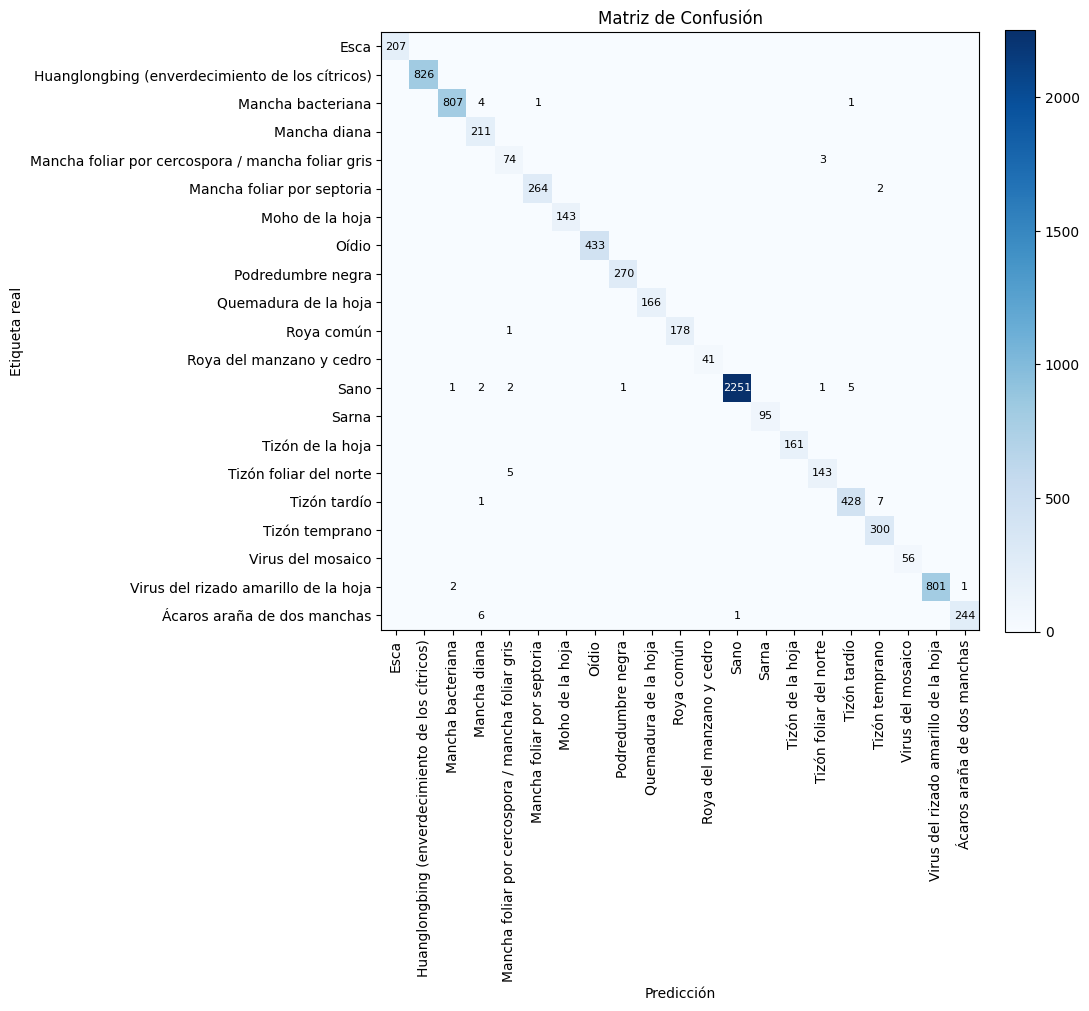

In [29]:
utils.plot_confusion_matrix_blue(y_true, y_pred, class_names, normalize=False)

## Conclusiones

Comparando los resultados con el modelo baseline vemos claras mejoras:

- La precision de la clase sana pasó de 0.92 a 0.99, somos mejores prediciendo hojas sin enfermedades. Pudimos corregir casos dónde las hojas presentaban signos casi impercetibles de enfermedad por ejemplo mancha diana y ácaros araña de dos manchas. Este último solo tuvo un falso positivo.


- El recall de las enfermedades mejoró notablemente llegando a 0.9998. Prácticamente no se le escapan casos de enfermedad, lo que es crucial en aplicaciones donde un falso negativo puede tener un impacto grave (en este caso, no tratar una planta enferma).

Las confusiones entre clases similares se reducen drásticamente. Partiendo del análisis en el que analizamos enfermedades similares podemos ver:

Si bien el modelo sigue confundiendo Mancha foliar gris y Tizón foliar del norte, el total de casos se redujo en un 68%. Más marcado es el caso de Mancha foliar por septoria y mancha bacteriana en el cuál el modelo casi que no se equivoca. 


Podemos afirmar qué las técnicas utilizadas como el entrenamiento en múltiples pasos, ajuste de FocalLoss con pesos de clase y la optimización progresiva del learning rate mediante ReduceLROnPlateau lograron mejorar trascendentalmente el modelo comparandolo con el baseline.